In [9]:
cd /deac/phy/salsburyGrp/wud18/md/TM/pca/

/deac/phy/salsburyGrp/wud18/md/TM/pca


In [10]:
import pyemma.coordinates as coor
import mdtraj as md
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 18})
pylab.rcParams['figure.figsize'] = (14, 11)
cwd = os.getcwd()

Populating the interactive namespace from numpy and matplotlib


In [11]:
def local_min(data,max0=6):
    lmin=[]
    for i in range(48):
        for j in range(48):
            if data[i+1][j] >= data[i][j] and\
               data[i-1][j] >= data[i][j] and\
               data[i][j+1] >= data[i][j] and\
               data[i][j-1] >= data[i][j] and\
               data[i+1][j+1] >= data[i][j] and\
               data[i+1][j-1] >= data[i][j] and\
               data[i-1][j+1] >= data[i][j] and\
               data[i-1][j-1] >= data[i][j] and\
               data[i+2][j] >= data[i][j] and\
               data[i-2][j] >= data[i][j] and\
               data[i][j+2] >= data[i][j] and\
               data[i][j-2] >= data[i][j] and\
               data[i+2][j+1] >= data[i][j] and\
               data[i+2][j-1] >= data[i][j] and\
               data[i-2][j+1] >= data[i][j] and\
               data[i-2][j-1] >= data[i][j] and\
               data[i+1][j+2] >= data[i][j] and\
               data[i+1][j-2] >= data[i][j] and\
               data[i-1][j+2] >= data[i][j] and\
               data[i-1][j-2] >= data[i][j] and\
               data[i+2][j+2] >= data[i][j] and\
               data[i+2][j-2] >= data[i][j] and\
               data[i-2][j+2] >= data[i][j] and\
               data[i-2][j-2] >= data[i][j] and\
               data[i][j] < max0:
                lmin.append([i,j])
    return lmin

In [12]:
def find_sub_min(brr, n):
    arr = brr.copy()
    if n==1:
        arr_ = arr
    else:
        for i in range(n-1):
            arr_ = arr
            arr_[np.argmin(arr_)] = np.max(arr)+0.000000000000001
            arr = arr_
    return np.argmin(arr_)

In [13]:
def examine_well(X,variance,comp1,comp2,type1,vmin,vmax,Title,outname,outputDir,num_of_rep):
    cmap = plt.cm.get_cmap("nipy_spectral")    
    cmap.set_bad('white',1.)
    figure(figsize = (6,4.5))
    nbins=50
    z,x,y = np.histogram2d(X[:,comp1],X[:,comp2], bins=nbins)
    x = 0.5*(x[:-1] + x[1:])
    y = 0.5*(y[:-1] + y[1:])
    overal_bound = [x[0], x[-1], y[0], y[-1]]
    xLabelName='PC{0} ({1:.2f}%)'.format(comp1+1, variance[comp1] * 100)
    yLabelName='PC{0} ({1:.2f}%)'.format(comp2+1, variance[comp2] * 100)
    
    # Histogram frames
    z,x,y = np.histogram2d(X[type1,comp1],X[type1,comp2], bins=nbins)
    x1 = 0.5*(x[:-1] + x[1:])
    y1 = 0.5*(y[:-1] + y[1:])
    extent=[x1[0], x1[-1], y1[0], y1[-1]]
    F1 = -np.log(z)
    F1-=np.min(F1)
    F1[np.where(F1==inf)]=nan
    
    # Positions and values of local minimum point
    lmin=local_min(F1,6)
    print('Local minimum points: ', lmin)
    Fv=[]
    for i in range(len(lmin)):
        Fv.append(F1[lmin[i][0],lmin[i][1]])

    # Plot heat map
    CS1 = contourf(F1.T, 100, cmap=cmap, extent=extent)
    cbar = colorbar(CS1)
    font = {
        #'family' : 'serif',
        #'color'  : 'darkred',
        #'weight' : 'normal',
        'size'   : 14}
    cbar.set_label('Free energy (kT)', fontdict=font)
    xlabel(xLabelName, fontsize=14)
    ylabel(yLabelName, fontsize=14)
    title(Title, fontsize=14)
    xlim(overal_bound[0],overal_bound[1])
    ylim(overal_bound[2],overal_bound[3])
    clim(vmin,vmax)
    
    for i in range(num_of_rep):
        # Find the most populated bin within the selected window
        bin_x,bin_y=lmin[find_sub_min(Fv,i+1)]
        boolean_in_X = np.logical_and(X[type1,comp1]<x[bin_x+1],X[type1,comp1]>x[bin_x])
        boolean_in_Y = np.logical_and(X[type1,comp2]<y[bin_y+1],X[type1,comp2]>y[bin_y])
        boolean_in_XY = np.logical_and(boolean_in_X, boolean_in_Y)
        print('# of frames within the most populated bin',boolean_in_XY.sum())
    
        # Find the representative frame
        binAverage_x = X[type1,comp1][boolean_in_XY].mean()
        binAverage_y = X[type1,comp2][boolean_in_XY].mean()
        distance2ToBinCenter = (X[type1,comp1][boolean_in_XY]-binAverage_x)**2 + \
        (X[type1,comp2][boolean_in_XY]-binAverage_y)**2
        representativeFrame = (type1[boolean_in_XY])[np.argmin(distance2ToBinCenter)]
        print("representativeFrame",representativeFrame)
    
        # Check the location of the representative frame
        text(X[type1,comp1][representativeFrame], X[type1,comp2][representativeFrame], i, fontsize=15, color='white', horizontalalignment='center', verticalalignment='center')
    
        # Write output files
        if not os.path.exists(os.path.join('visualization', outname, outputDir+str(i))):
            os.makedirs(os.path.join('visualization', outname, outputDir+str(i)))
    
        representative_frame = md.load_frame(trajfile,representativeFrame,top = topfile)
        representative_frame.save_pdb(os.path.join('visualization', outname, outputDir+str(i), 'rep.pdb'))
        pca_well_sample = np.column_stack((np.zeros(type1[boolean_in_XY].size),type1[boolean_in_XY]))
        pca_well_sample=pca_well_sample.astype(int)
        coor.save_traj(inp, pca_well_sample, os.path.join('visualization', outname, outputDir+str(i), 'all.dcd'))
    
    # Saving figures
    comp1=str(comp1+1)
    comp2=str(comp2+1)
    outname2=outname+'_PC_'+comp1+'_'+comp2
    
    fig_dir = os.path.join('./figs_togather_wells/',outname)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    plt.savefig(os.path.join(fig_dir,outname2+'.png'), pad_inches=0.03, bbox_inches='tight', dpi=200)
    plt.savefig(os.path.join(fig_dir,outname2+'.tiff'), pad_inches=0.03, bbox_inches='tight', dpi=600)
    plt.savefig(os.path.join(fig_dir,outname2+'.pdf'), bbox_inches='tight')

In [14]:
path = '/deac/phy/salsburyGrp/wud18/md/TM/'

In [15]:
# Loading trajectory
stride=1
topfile = path+'protein_right_angle.pdb'
topology = md.load(topfile).topology
trajfile = path+'thrombin_TM56_TM456_stride' + str(stride) + '_aligned.dcd'
feat = coor.featurizer(topfile)
inp = coor.source(trajfile, feat)
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())
all=np.arange(inp.trajectory_length(0))

trajectory length =  2400000
number of dimension =  14175


In [8]:
# Catalytic Pocket
catalyticPocket_pca=np.load(path+'pca/PcaBasisFromAll/catalyticPockets/projection.npy')
catalyticPocket_variance=np.load(path+'pca/PcaBasisFromAll/catalyticPockets/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[6, 29], [16, 41], [21, 39], [30, 23], [31, 12], [35, 21], [36, 7], [41, 12]]
# of frames within the most populated bin 29061
representativeFrame 398963


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


14-04-22 23:05:21 pyemma.coordinates.api INFO     Created file visualization/catalyticPocket/cluster0/all.dcd
# of frames within the most populated bin 17636
representativeFrame 2081546
14-04-22 23:06:16 pyemma.coordinates.api INFO     Created file visualization/catalyticPocket/cluster1/all.dcd
# of frames within the most populated bin 7347
representativeFrame 909459
14-04-22 23:06:46 pyemma.coordinates.api INFO     Created file visualization/catalyticPocket/cluster2/all.dcd
# of frames within the most populated bin 1291
representativeFrame 2170124
14-04-22 23:06:52 pyemma.coordinates.api INFO     Created file visualization/catalyticPocket/cluster3/all.dcd
# of frames within the most populated bin 1133
representativeFrame 794982
14-04-22 23:06:57 pyemma.coordinates.api INFO     Created file visualization/catalyticPocket/cluster4/all.dcd
# of frames within the most populated bin 1057
representativeFrame 2292250
14-04-22 23:07:02 pyemma.coordinates.api INFO     Created file visualization

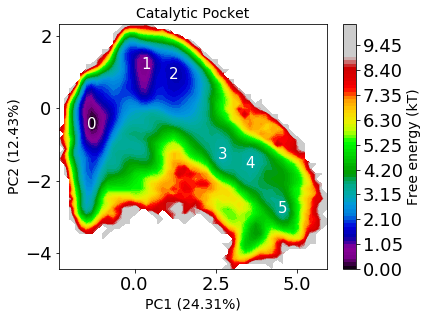

In [9]:
examine_well(catalyticPocket_pca,catalyticPocket_variance,0,1,all,0,9,'Catalytic Pocket','catalyticPocket','cluster',6)

In [10]:
# Regulatory Loops
regulatoryLoops_pca=np.load(path+'pca/PcaBasisFromAll/regulatoryLoops/projection.npy')
regulatoryLoops_variance=np.load(path+'pca/PcaBasisFromAll/regulatoryLoops/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[8, 17], [11, 33], [18, 35], [20, 24], [21, 15], [24, 8], [26, 15], [27, 29], [28, 19], [28, 39], [31, 23], [32, 5], [32, 18], [35, 4], [35, 12], [39, 26], [40, 36], [43, 23], [44, 14]]
# of frames within the most populated bin 9762
representativeFrame 1298299


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


07-04-22 01:23:04 pyemma.coordinates.api INFO     Created file visualization/regulatoryLoops/cluster0/all.dcd
# of frames within the most populated bin 7715
representativeFrame 960453
07-04-22 01:23:14 pyemma.coordinates.api INFO     Created file visualization/regulatoryLoops/cluster1/all.dcd
# of frames within the most populated bin 7642
representativeFrame 2241728
07-04-22 01:23:37 pyemma.coordinates.api INFO     Created file visualization/regulatoryLoops/cluster2/all.dcd
# of frames within the most populated bin 6445
representativeFrame 1306170
07-04-22 01:24:02 pyemma.coordinates.api INFO     Created file visualization/regulatoryLoops/cluster3/all.dcd
# of frames within the most populated bin 6025
representativeFrame 2140637
07-04-22 01:24:20 pyemma.coordinates.api INFO     Created file visualization/regulatoryLoops/cluster4/all.dcd
# of frames within the most populated bin 4831
representativeFrame 740708
07-04-22 01:24:36 pyemma.coordinates.api INFO     Created file visualization/

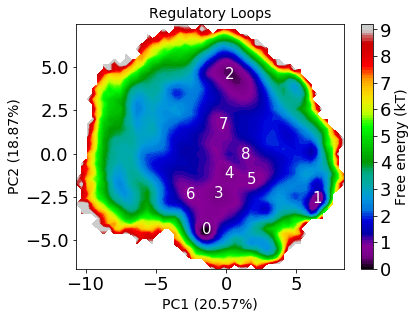

In [11]:
examine_well(regulatoryLoops_pca,regulatoryLoops_variance,0,1,all,0,9,'Regulatory Loops','regulatoryLoops','cluster',9)

In [12]:
# 60s Loop
sixtysLoop_pca=np.load(path+'pca/PcaBasisFromAll/60sLoop/projection.npy')
sixtysLoop_variance=np.load(path+'pca/PcaBasisFromAll/60sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[9, 41], [10, 32], [15, 11], [21, 34], [22, 13], [22, 34], [40, 32], [44, 29]]
# of frames within the most populated bin 50649
representativeFrame 854992


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


07-04-22 01:28:01 pyemma.coordinates.api INFO     Created file visualization/60sLoop/cluster0/all.dcd
# of frames within the most populated bin 36480
representativeFrame 2088848
07-04-22 01:29:56 pyemma.coordinates.api INFO     Created file visualization/60sLoop/cluster1/all.dcd
# of frames within the most populated bin 1215
representativeFrame 2297040
07-04-22 01:30:01 pyemma.coordinates.api INFO     Created file visualization/60sLoop/cluster2/all.dcd
# of frames within the most populated bin 901
representativeFrame 773603
07-04-22 01:30:05 pyemma.coordinates.api INFO     Created file visualization/60sLoop/cluster3/all.dcd


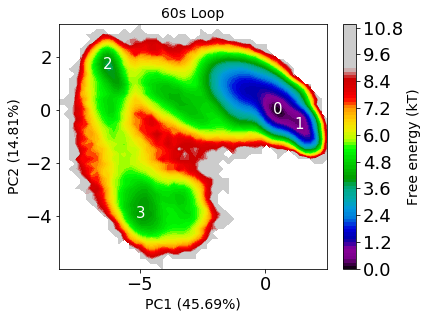

In [13]:
examine_well(sixtysLoop_pca,sixtysLoop_variance,0,1,all,0,9,'60s Loop','60sLoop','cluster',4)

In [14]:
# Helix1 (residue 158 to 166)
helix1_pca=np.load(path+'pca/PcaBasisFromAll/helix1/projection.npy')
helix1_variance=np.load(path+'pca/PcaBasisFromAll/helix1/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[19, 39], [22, 17], [30, 20]]
# of frames within the most populated bin 14726
representativeFrame 1835516


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


07-04-22 01:31:17 pyemma.coordinates.api INFO     Created file visualization/helix1/cluster0/all.dcd
# of frames within the most populated bin 5256
representativeFrame 577383
07-04-22 01:31:41 pyemma.coordinates.api INFO     Created file visualization/helix1/cluster1/all.dcd
# of frames within the most populated bin 615
representativeFrame 379435
07-04-22 01:31:44 pyemma.coordinates.api INFO     Created file visualization/helix1/cluster2/all.dcd


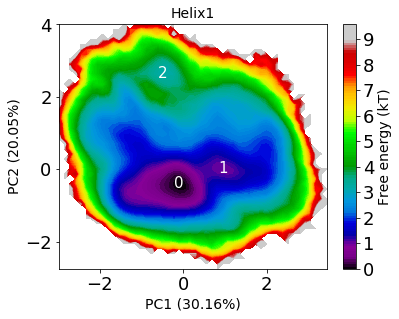

In [15]:
examine_well(helix1_pca,helix1_variance,0,1,all,0,9,'Helix1','helix1','cluster',3)

In [10]:
# Gamma Loop
gammaLoop_pca=np.load(path+'pca/PcaBasisFromAll/gammaLoop/projection.npy')
gammaLoop_variance=np.load(path+'pca/PcaBasisFromAll/gammaLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[8, 34], [11, 19], [18, 14], [20, 35], [24, 42], [25, 24], [26, 35], [27, 20], [28, 10], [28, 30], [33, 31], [35, 37], [35, 45], [38, 21], [43, 25], [44, 34]]
# of frames within the most populated bin 11424
representativeFrame 1384567


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


14-04-22 23:07:29 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster0/all.dcd
# of frames within the most populated bin 7757
representativeFrame 732218
14-04-22 23:08:01 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster1/all.dcd
# of frames within the most populated bin 7032
representativeFrame 940780
14-04-22 23:08:13 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster2/all.dcd
# of frames within the most populated bin 6299
representativeFrame 482033
14-04-22 23:08:36 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster3/all.dcd
# of frames within the most populated bin 6220
representativeFrame 1448362
14-04-22 23:08:59 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster4/all.dcd
# of frames within the most populated bin 4887
representativeFrame 2151648
14-04-22 23:09:17 pyemma.coordinates.api INFO     Created file visualization/gammaLoop/cluster5/all.dcd
# of

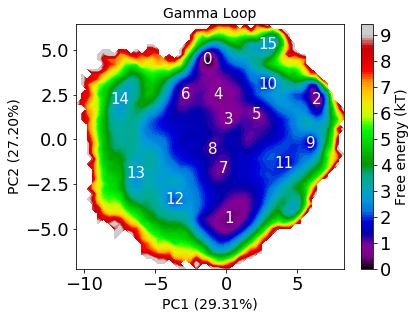

In [11]:
examine_well(gammaLoop_pca,gammaLoop_variance,0,1,all,0,9,'Gamma Loop','gammaLoop','cluster',16)

In [18]:
# 170s Loop (residue 205 to 212)
I70sLoop_pca=np.load(path+'pca/PcaBasisFromAll/170sLoop/projection.npy')
I70sLoop_variance=np.load(path+'pca/PcaBasisFromAll/170sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[6, 20], [12, 30], [19, 13], [34, 29], [40, 14]]
# of frames within the most populated bin 12110
representativeFrame 1510634


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


07-04-22 01:35:45 pyemma.coordinates.api INFO     Created file visualization/170sLoop/cluster0/all.dcd
# of frames within the most populated bin 3832
representativeFrame 1454331
07-04-22 01:36:03 pyemma.coordinates.api INFO     Created file visualization/170sLoop/cluster1/all.dcd
# of frames within the most populated bin 1944
representativeFrame 296508
07-04-22 01:36:10 pyemma.coordinates.api INFO     Created file visualization/170sLoop/cluster2/all.dcd
# of frames within the most populated bin 663
representativeFrame 1653165
07-04-22 01:36:13 pyemma.coordinates.api INFO     Created file visualization/170sLoop/cluster3/all.dcd


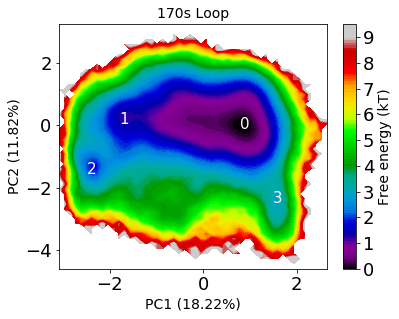

In [19]:
examine_well(I70sLoop_pca,I70sLoop_variance,0,1,all,0,9,'170s Loop','170sLoop','cluster',4)

In [20]:
# 180s Loop (residue 205 to 212)
I80sLoop_pca=np.load(path+'pca/PcaBasisFromAll/180sLoop/projection.npy')
I80sLoop_variance=np.load(path+'pca/PcaBasisFromAll/180sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[13, 29], [24, 16], [25, 14], [25, 31], [26, 11], [34, 34]]
# of frames within the most populated bin 22162
representativeFrame 1898277


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


07-04-22 01:37:44 pyemma.coordinates.api INFO     Created file visualization/180sLoop/cluster0/all.dcd
# of frames within the most populated bin 6320
representativeFrame 1175843
07-04-22 01:38:16 pyemma.coordinates.api INFO     Created file visualization/180sLoop/cluster1/all.dcd
# of frames within the most populated bin 5750
representativeFrame 2173488
07-04-22 01:38:40 pyemma.coordinates.api INFO     Created file visualization/180sLoop/cluster2/all.dcd
# of frames within the most populated bin 1172
representativeFrame 1654292
07-04-22 01:38:45 pyemma.coordinates.api INFO     Created file visualization/180sLoop/cluster3/all.dcd


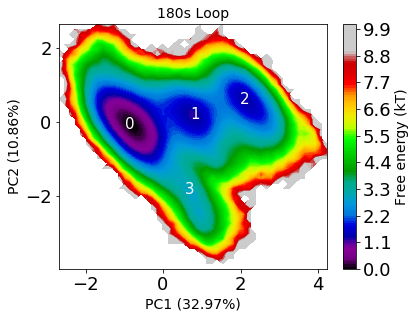

In [21]:
examine_well(I80sLoop_pca,I80sLoop_variance,0,1,all,0,9,'180s Loop','180sLoop','cluster',4)

In [22]:
# Sodium Loop
sodiumLoop_pca=np.load(path+'pca/PcaBasisFromAll/sodiumLoop/projection.npy')
sodiumLoop_variance=np.load(path+'pca/PcaBasisFromAll/sodiumLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[7, 20], [22, 12], [32, 26], [37, 34], [42, 42]]
# of frames within the most populated bin 32750
representativeFrame 666544


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


07-04-22 01:40:30 pyemma.coordinates.api INFO     Created file visualization/220sLoop/cluster0/all.dcd
# of frames within the most populated bin 16633
representativeFrame 551873
07-04-22 01:41:34 pyemma.coordinates.api INFO     Created file visualization/220sLoop/cluster1/all.dcd
# of frames within the most populated bin 2688
representativeFrame 1680139
07-04-22 01:41:43 pyemma.coordinates.api INFO     Created file visualization/220sLoop/cluster2/all.dcd
# of frames within the most populated bin 1017
representativeFrame 376721
07-04-22 01:41:47 pyemma.coordinates.api INFO     Created file visualization/220sLoop/cluster3/all.dcd


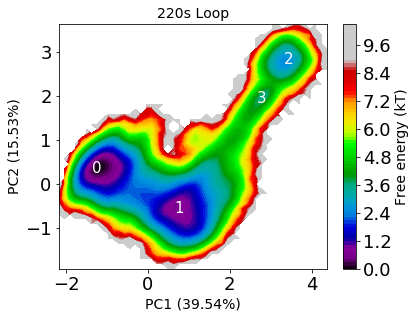

In [23]:
examine_well(sodiumLoop_pca,sodiumLoop_variance,0,1,all,0,9,'220s Loop','220sLoop','cluster',4)

In [24]:
# Catalytic Triad
catalyticTriad_pca=np.load(path+'pca/PcaBasisFromAll/catalyticTriad/projection.npy')
catalyticTriad_variance=np.load(path+'pca/PcaBasisFromAll/catalyticTriad/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[27, 17]]
# of frames within the most populated bin 17753
representativeFrame 674126


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


07-04-22 01:43:13 pyemma.coordinates.api INFO     Created file visualization/catalyticTriad/cluster0/all.dcd


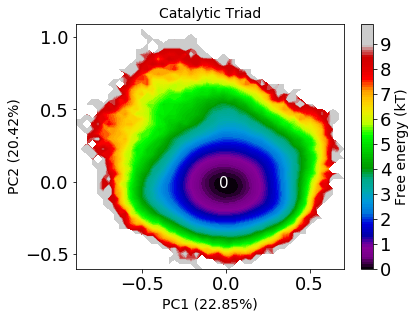

In [25]:
examine_well(catalyticTriad_pca,catalyticTriad_variance,0,1,all,0,9,'Catalytic Triad','catalyticTriad','cluster',1)

In [16]:
# Exosite I
exositeI_pca=np.load(path+'pca/PcaBasisFromAll/exositeI/projection.npy')
exositeI_variance=np.load(path+'pca/PcaBasisFromAll/exositeI/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[8, 26], [39, 19], [40, 14]]
# of frames within the most populated bin 19921
representativeFrame 1025984


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


07-06-23 21:49:19 pyemma.coordinates.api INFO     Created file visualization/exositeI/cluster0/all.dcd
# of frames within the most populated bin 417
representativeFrame 93339
07-06-23 21:49:22 pyemma.coordinates.api INFO     Created file visualization/exositeI/cluster1/all.dcd


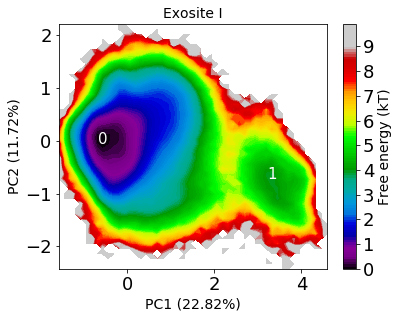

In [17]:
examine_well(exositeI_pca,exositeI_variance,0,1,all,0,9,'Exosite I','exositeI','cluster',2)

In [18]:
# Exosite II
exositeII_pca=np.load(path+'pca/PcaBasisFromAll/exositeII/projection.npy')
exositeII_variance=np.load(path+'pca/PcaBasisFromAll/exositeII/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[10, 27], [19, 35], [28, 21]]
# of frames within the most populated bin 14285
representativeFrame 1042683


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


07-06-23 21:50:39 pyemma.coordinates.api INFO     Created file visualization/exositeII/cluster0/all.dcd
# of frames within the most populated bin 6804
representativeFrame 1910658
07-06-23 21:51:12 pyemma.coordinates.api INFO     Created file visualization/exositeII/cluster1/all.dcd
# of frames within the most populated bin 1313
representativeFrame 1383759
07-06-23 21:51:20 pyemma.coordinates.api INFO     Created file visualization/exositeII/cluster2/all.dcd


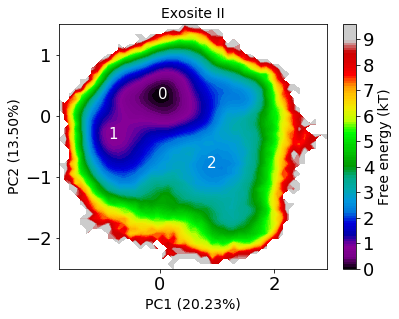

In [19]:
examine_well(exositeII_pca,exositeII_variance,0,1,all,0,9,'Exosite II','exositeII','cluster',3)

In [30]:
# Connection
connection_pca=np.load(path+'pca/PcaBasisFromAll/connection/projection.npy')
connection_variance=np.load(path+'pca/PcaBasisFromAll/connection/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[14, 29], [31, 20]]
# of frames within the most populated bin 21029
representativeFrame 1221452


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


07-04-22 01:47:12 pyemma.coordinates.api INFO     Created file visualization/connection/cluster0/all.dcd
# of frames within the most populated bin 396
representativeFrame 542159
07-04-22 01:47:14 pyemma.coordinates.api INFO     Created file visualization/connection/cluster1/all.dcd


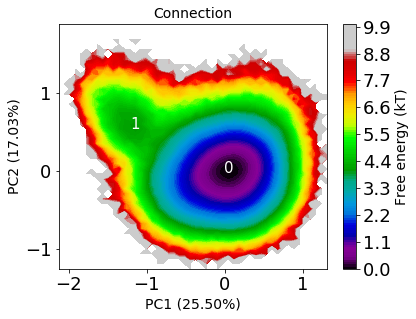

In [31]:
examine_well(connection_pca,connection_variance,0,1,all,0,9,'Connection','connection','cluster',2)

In [32]:
# 30s Loop
thirtysLoop_pca=np.load(path+'pca/PcaBasisFromAll/30sLoop/projection.npy')
thirtysLoop_variance=np.load(path+'pca/PcaBasisFromAll/30sLoop/variance.npy')

/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Local minimum points:  [[18, 23]]
# of frames within the most populated bin 25767
representativeFrame 1124561


/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1858: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/wud18/install/anaconda3/envs/py36/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1861: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


07-04-22 01:47:22 pyemma.coordinates.api INFO     Created file visualization/30sLoop/cluster0/all.dcd


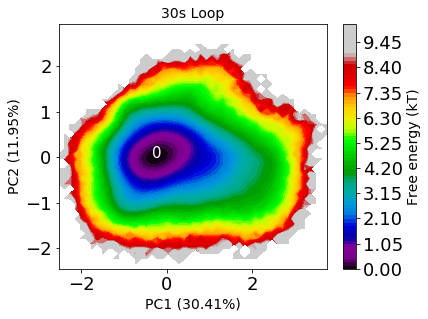

In [33]:
examine_well(thirtysLoop_pca,thirtysLoop_variance,0,1,all,0,9,'30s Loop','30sLoop','cluster',1)

In [32]:
# Helix2 (residue 205 to 212)
helix2_pca=np.load(path+'pca/PcaBasisFromAll/helix2/projection.npy')
helix2_variance=np.load(path+'pca/PcaBasisFromAll/helix2/variance.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/deac/salsburyGrp/wud18/md/TM/pca/PcaBasisFromAll/helix2/projection.npy'

In [ ]:
examine_well(helix2_pca,helix2_variance,0,1,all,0,9,'Helix2','helix2','cluster',1)

In [ ]:
# Beta Sheet1
betaSheet1_pca=np.load(path+'pca/PcaBasisFromAll/betaSheet1/projection.npy')
betaSheet1_variance=np.load(path+'pca/PcaBasisFromAll/betaSheet1/variance.npy')

In [ ]:
examine_well(betaSheet1_pca,betaSheet1_variance,0,1,all,0,9,'Beta Sheet1','betaSheet1','cluster',2)